In [216]:
import torch
from torchvision import datasets, transforms as T
import torch.utils.data
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import helper

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import os
import os.path as path
import xml.etree.ElementTree as ET

## Setup directories

In [218]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    is_colab = True

    from google.colab import drive
    cwdir = "drive/My Drive"
    drive.mount("/content/drive")
    os.chdir(cwdir)

    synthetic_data_dir = "./data/synthetic_data"
else:
    print('Not running on CoLab')
    is_colab = False
    
    if os.path.basename(os.path.normpath(os.getcwd())) != "BeeWatch":
        os.chdir('..')
        cw_dir = os.getcwd()
        
    synthetic_data_dir = "./dataset/synthetic_data"

    
annotation_path = path.join(synthetic_data_dir, "annots")
images_path = path.join(synthetic_data_dir, "images")

print(f"Working directory set to: {os.getcwd()}")
print(f"Annotations directory: {annotation_path}")
print(f"Images diectory: {images_path}")

Not running on CoLab
Working directory set to: /Users/maximiliannitsche/KIT/AISS - CV/BeeWatch


## Visualize example image object detection

**Load example image**

In [68]:
example_image = Image.open(path.join(images_path, "0.jpg"))

**Load example annotation**

In [98]:
def read_annotation(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

name, boxes = read_content(path.join(annotation_path, "0.xml"))

In [70]:
boxes[0]

[107, 303, 156, 352]

**Visualize Bounding Boxes and Image**

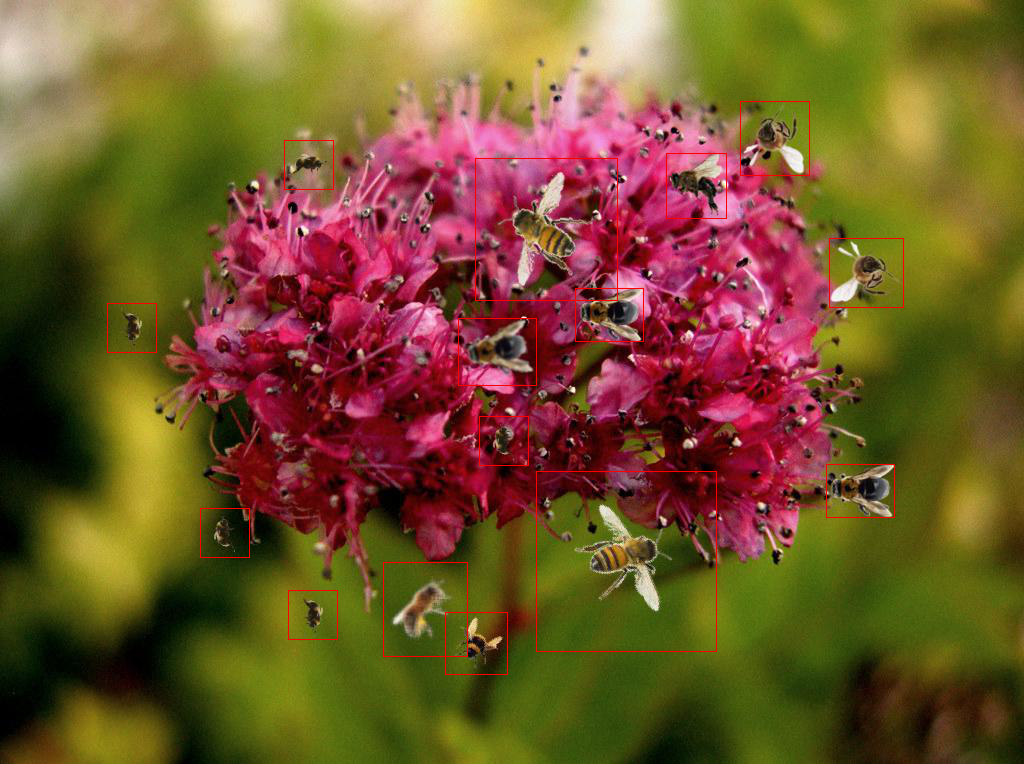

In [71]:
draw = ImageDraw.Draw(example_image)
for bb in boxes:
    draw.rectangle([(bb[0], bb[1]), (bb[2], bb[3])], outline ="red")
example_image

## Create Dataset Object

In [148]:
class BeeDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_imgs=images_path, path_to_annots=annotation_path, transforms=None):
        self.path_to_imags = path_to_imgs
        self.path_to_annots = path_to_annots
        self.image_ids = sorted(os.listdir(images_path))
        self.transforms = transforms

    def __getitem__(self, idx):
        img_id = os.path.splitext(self.image_ids[idx])[0]
        img = Image.open(os.path.join(self.path_to_imags, img_id + ".jpg"))
        _, bboxes = read_annotation(os.path.join(self.path_to_annots, img_id + ".xml"))
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        
        num_objs = len(bboxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:,0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
        
    def __len__(self):
        return len(self.image_ids)

In [149]:
BeeDataset().__getitem__(0)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x764 at 0x7FFEDB4057F0>,
 {'boxes': [[107, 303, 156, 352],
   [445, 612, 507, 674],
   [383, 562, 467, 656],
   [829, 238, 903, 307],
   [740, 101, 809, 175],
   [666, 153, 726, 218],
   [536, 471, 716, 651],
   [475, 158, 617, 300],
   [575, 288, 643, 341],
   [826, 464, 894, 517],
   [458, 318, 536, 385],
   [200, 508, 249, 557],
   [479, 416, 528, 465],
   [284, 140, 333, 189],
   [288, 590, 337, 639]],
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([0]),
  'area': tensor([ 2401.,  3844.,  7896.,  5106.,  5106.,  3900., 32400., 20164.,  3604.,
           3604.,  5226.,  2401.,  2401.,  2401.,  2401.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])})

In [150]:
def get_model():
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    num_classes = 1 #Only bees
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [191]:
def get_transform(train):
    """Returns pipeline of transformers.
    
    Params:
        train (bool): Training or prediction
    """
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Grayscale())
    transforms.append(T.RandomResizedCrop((1024,1024)))
                      
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
                      
    return T.Compose(transforms)

In [210]:
dataset = BeeDataset(transforms=get_transform(train=True))
dataset_test = BeeDataset(transforms=get_transform(train=False))

In [211]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)
print("{} examples: {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

100 examples: 60 are training and 40 testing


In [212]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model = get_model()
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cpu


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [213]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [81]:
# Model
#model = torch.hub.load('ultralytics/yolov5', 'yolov5x6', pretrained=True)

Using cache found in /Users/maximiliannitsche/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 606 layers, 141755500 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-6-5 torch 1.8.1 CPU



In [84]:
transform = transforms.Compose([transforms.RandomResizedCrop((1024,1024)),
                                transforms.Grayscale(),
                                transforms.ColorJitter(saturation=0.5),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

In [ ]:
dataset = datasets.ImageFolder(image_path, transform=transform)

tensor(0.)

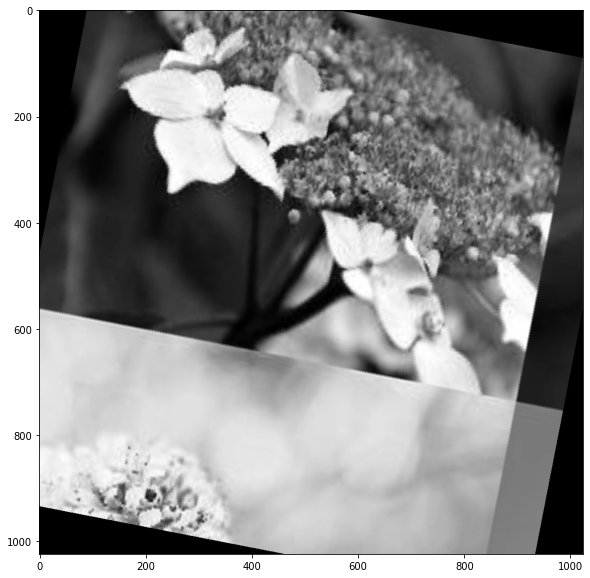

In [88]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
images, labels = next(iter(dataloader))

plt.figure(figsize=(20,10))
plt.imshow(images[0].reshape((images[0].shape[1], images[0].shape[2])), cmap=plt.cm.gray)
images[0].min()